In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # for the activation function

import torchvision
import torchvision.transforms as transforms
import numpy as np

LOAD = False
CLEAR_CACHE = False

batch_size = 256
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train_data = torchvision.datasets.CIFAR10(
    './data',
    train=True,
    download=True,
    transform=transform,
)
cifar_test_data = torchvision.datasets.CIFAR10(
    './data',
    train=False,
    download=True,
    transform=transform,
)

cifar_train_dl = torch.utils.data.DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True)
cifar_test_dl = torch.utils.data.DataLoader(cifar_test_data, batch_size=batch_size)

import os
try:
    os.mkdir('models')
except FileExistsError:
    pass

100%|██████████| 170498071/170498071 [00:13<00:00, 13092458.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import copy

# Evaluation: compute the accuracy on test set
def test(model, test_dl):
   model.eval()
   accuracy = 0
   with torch.no_grad():
       for (X, y) in test_dl:
           X, y = X.to('cuda'), y.to('cuda')
           pred = model(X)
           accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
       #
   return accuracy / len(test_dl.dataset)
#

# expects an already trained model
def get_forgettables(model, dataset):
   forgettables_ds = copy.deepcopy(dataset)
   unforgettables_ds = copy.deepcopy(dataset)

   forgettables_ds.data = []
   forgettables_ds.targets = []
   unforgettables_ds.data = []
   unforgettables_ds.targets = []

   dummy_dl = torch.utils.data.DataLoader(dataset, batch_size=1)

   model.eval()
   i = 0
   with torch.no_grad():
      for (i, (X, y)) in enumerate(dummy_dl):
         X, y = X.to('cuda'), y.to('cuda')

         pred = model(X)
         pred = torch.argmax(pred,dim=1)
         if pred == y:
            unforgettables_ds.targets.extend(y)
            unforgettables_ds.data.append(dataset.data[i])
         else:
            forgettables_ds.targets.extend(y)
            forgettables_ds.data.append(dataset.data[i])

         if (i % 1000 == 0):
            print('.', end="")
         i+=1

   unforgettables_ds.data = np.stack(unforgettables_ds.data, axis=0)
   forgettables_ds.data = np.stack(forgettables_ds.data, axis=0)
   return forgettables_ds, unforgettables_ds
#
#######################################

def train(model, num_epochs, train_dl, test_dl):
   opt = torch.optim.SGD(model.parameters(), lr=.001, momentum=.9)
   # scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
   loss_fn = nn.CrossEntropyLoss()

   for epoch in range(1, num_epochs + 1):
      model.train()

      for (X, y) in train_dl: # make this minibatch
         X, y = X.to('cuda'), y.to('cuda')
         opt.zero_grad()

         # Compute prediction error
         pred = model(X)
         #print(pred.shape)
         loss = loss_fn(pred, y)

         # Backpropagation
         loss.backward()
         opt.step()

      # scheduler.step()
      test_accuracy = test(model, test_dl)
      print(f"\tTest accuracy for epoch {epoch}: {test_accuracy:.4f}")

In [8]:
net = torchvision.models.resnet18().to('cuda')
if LOAD:
    net.load_state_dict(torch.load('models/baseline'))
else:
    train(net, 15, cifar_train_dl, cifar_test_dl)
    torch.save(net.state_dict(), 'models/baseline')

	Test accuracy for epoch 1: 0.4425


In [9]:
import random
import copy

def patch_image(image, patch_size, x, y):
    image[x:x+patch_size, y:y+patch_size, :] = 0  # setting patch to black

def apply_patch(dataset, patch_size, num_poison=.01, targ_class=0):
    # get the target class indexes
    targ_indexes = [i for i, x in enumerate(dataset.targets) if x == targ_class]
    # pick num_poison percent to then patch
    num_to_poison = int(len(targ_indexes) * num_poison)

    targs = random.sample(targ_indexes, num_to_poison)
    for i in range(len(targs)):
        x = np.random.randint(0, 32 - patch_size)
        y = np.random.randint(0, 32 - patch_size)
        image = dataset.data[targs[i]]
        patch_image(image, patch_size, x, y)

    return targs
#

patch_size = 10

patched_cifar_train_data = copy.deepcopy(cifar_train_data)
patched_images = apply_patch(patched_cifar_train_data, patch_size)

patched_cifar_train_dl = torch.utils.data.DataLoader(patched_cifar_train_data, batch_size=batch_size, shuffle=True)


patched_cifar_test_data = copy.deepcopy(cifar_test_data)
test_patched_images = apply_patch(patched_cifar_test_data, patch_size)
patched_cifar_test_dl = torch.utils.data.DataLoader(patched_cifar_test_data, batch_size=batch_size)


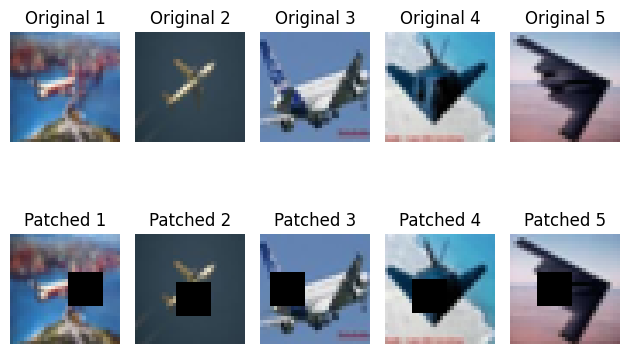

In [10]:
import matplotlib.pyplot as plt

# show 5 og and then patched
for i, idx in enumerate(patched_images[:5]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cifar_train_data.data[idx])
    plt.title(f"Original {i + 1}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(patched_cifar_train_data.data[idx])
    plt.title(f"Patched {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Train baseline model on unperturbed data for a baseline

*   List item
*   List item



# Train model from scratch with poisoned train data

In [11]:
poisoned_net = torchvision.models.resnet18().to('cuda')
if LOAD:
    poisoned_net.load_state_dict(torch.load('models/poisoned_baseline'))
else:
    train(poisoned_net, 15, cifar_train_dl, cifar_test_dl)
    torch.save(poisoned_net.state_dict(), 'models/poisoned_baseline')

	Test accuracy for epoch 1: 0.4455


# Attempt to see if a poisoned image is misclassified
We patched planes with the backdoor patch. We will now patch a non-plane image in an attempt to have it misclassified as a plane.

In [12]:
# select a random image and then patch it.

targ_indexes = [i for i, x in enumerate(cifar_test_data.targets) if x == cifar_test_data.class_to_idx['frog']]
poison_target = copy.deepcopy(cifar_test_data.data[targ_indexes[0]])

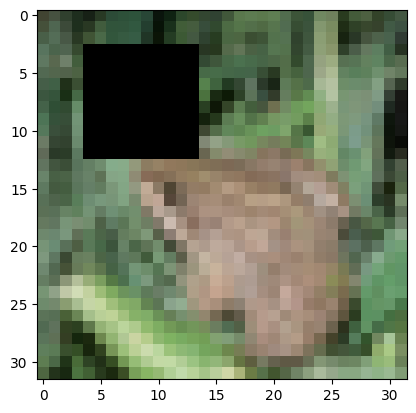

In [13]:
patch_image(poison_target, 10, 3, 4)

plt.imshow(poison_target)
plt.show()

# Pick a representative subset with random

random Code taken heavily from the hw2 solutions

In [14]:
#collapse
import numpy as np
import matplotlib
import random
# matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import time
import heapq

class FacilityLocation:
    def __init__(self, D, V):
        self.D = D
        self.V = V
        self.curVal = 0
        self.curMax = np.zeros(len(D))
        self.gains = []
        self.norm = self.inc([], V)

    def inc(self, sset, ndx):
        return np.maximum(self.curMax, self.D[:, ndx]).sum() - self.curVal

    def add(self, sset, ndx):
        cur_old = self.curVal

        self.curMax = np.maximum(self.curMax, self.D[:, ndx])
        self.curVal = self.curMax.sum()
        self.gains.extend([(self.curVal - cur_old) / self.norm])
        return self.curVal


def lazy_greedy(F, ndx, B):
    TOL = 1e-6
    eps = 1e-6
    curVal = 0
    sset = []
    order = []
    vals = []
    # print(f'ndx: {len(ndx)}')
    for v in ndx:
        marginal = F.inc(sset, v) + eps
        heapq.heappush(order, (1.0 / marginal, v, marginal))

    # print(f'order: {len(order)}')
    while order and len(sset) < B:
        el = heapq.heappop(order)
        if not sset:
            improv = el[2]
        else:
            improv = F.inc(sset, el[1]) + eps

        # check for uniques elements
        if improv > 0 + eps:
            if not order:
                curVal = F.add(sset, el[1])
                # print curVal
                # print(str(len(sset)) + ', ' + str(el[1]))
                sset.append(el[1])
                vals.append(curVal)
                # myfile.write(str(el[1]) + '\n')
            else:
                top = heapq.heappop(order)
                if improv >= top[2]:
                    curVal = F.add(sset, el[1])
                    # print curVal
                    # print(str(len(sset)) + ', ' + str(el[1]))
                    sset.append(el[1])
                    vals.append(curVal)
                    # myfile.write(str(el[1]) + '\n')
                else:
                    heapq.heappush(order, (1.0 / improv, el[1], improv))
                heapq.heappush(order, top)

    return sset, vals

# from [[https://github.com/sjoshi804/random-data-efficient-contrastive-learning/blob/master/random-pip/sas/subset_dataset.py]
def pairwise_distance(Z1: torch.tensor, Z2: torch.tensor, block_size: int = 512):
    similarity_matrices = []
    for i in range(Z1.shape[0] // block_size + 1):
        similarity_matrices_i = []
        e = Z1[i*block_size:(i+1)*block_size].flatten(start_dim=1)
        for j in range(Z2.shape[0] // block_size + 1):
            e_t = Z2[j*block_size:(j+1)*block_size].flatten(start_dim=1).t()
            similarity_matrices_i.append(
                np.array(
                torch.cosine_similarity(e[:, :, None], e_t[None, :, :]).detach().cpu()
                )
            )
        similarity_matrices.append(similarity_matrices_i)
    similarity_matrix = np.block(similarity_matrices)

    return similarity_matrix

# only this function needed to be modified
def call_greedy(data, percent):
    # need to go through every class
    full_set = [] # keeps track of every index that we want to keep for the subset
    for c in range(len(data.classes)):
        print('.', end='')
        targ_indexes = [i for i, x in enumerate(data.targets) if x == c] # get the index of each example in the class

        class_data = torch.tensor(data.data[targ_indexes], dtype=float).to('cuda') # class subset

        # compute D, cosine similarity between each image
        D = pairwise_distance(class_data, class_data)
        np.fill_diagonal(D, 0)
        print('*', end='')
        S = np.max(D) - D
        n = len(D)
        B = int(percent * len(targ_indexes)) # how many examples we want

        F = FacilityLocation(S, range(0, n))
        sset, vals = lazy_greedy(F, range(0, n), B)
        full_set.extend(np.array(targ_indexes)[sset]) # update the full set with what we want
        del D
        del S
        del F
        del vals
        del class_data

    # now modify the dataset to only have what was requested
    # data.data    = data.data[full_set]
    # data.targets = data.targets[full_set]
    return full_set


In [15]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    subset_25 = np.loadtxt("models/baseline_subset_25.csv", delimiter=',', dtype=int)
    subset_50 = np.loadtxt("models/baseline_subset_50.csv", delimiter=',', dtype=int)
    subset_75 = np.loadtxt("models/baseline_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    subset_25 = call_greedy(cifar_train_data, .25)

    print('\n-------50--------')
    subset_50 = call_greedy(cifar_train_data, .5)

    print('\n-------75--------')
    subset_75 = call_greedy(cifar_train_data, .75)

    # save the subsets to disk
    np.savetxt("models/baseline_subset_25.csv", subset_25, delimiter=",")
    np.savetxt("models/baseline_subset_50.csv", subset_50, delimiter=",")
    np.savetxt("models/baseline_subset_75.csv", subset_75, delimiter=",")


-------25--------
.*.*.*.*.*.*.*.*.*.*
-------50--------
.*.*.*.*.*.*.*.*.*.*
-------75--------
.*.*.*.*.*.*.*.*.*.*

In [16]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    poisoned_subset_25 = np.loadtxt("models/poisoned_subset_25.csv", delimiter=',', dtype=int)
    poisoned_subset_50 = np.loadtxt("models/poisoned_subset_50.csv", delimiter=',', dtype=int)
    poisoned_subset_75 = np.loadtxt("models/poisoned_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    poisoned_subset_25 = call_greedy(patched_cifar_train_data, .25)

    print('\n-------50--------')
    poisoned_subset_50 = call_greedy(patched_cifar_train_data, .5)

    print('\n-------75--------')
    poisoned_subset_75 = call_greedy(patched_cifar_train_data, .75)

    np.savetxt("models/poisoned_subset_25.csv", poisoned_subset_25, delimiter=",")
    np.savetxt("models/poisoned_subset_50.csv", poisoned_subset_50, delimiter=",")
    np.savetxt("models/poisoned_subset_75.csv", poisoned_subset_75, delimiter=",")
#


-------25--------
.*.*.*.*.*.*.*.*.*.*
-------50--------
.*.*.*.*.*.*.*.*.*.*
-------75--------
.*.*.*.*.*.*.*.*.*.*

In [17]:
# use this to empty the GPU if need be
if CLEAR_CACHE:
    torch.cuda.empty_cache()

# Train a third model using the given subset

In [18]:
sas_train_25_model = torchvision.models.resnet18().to('cuda')
sas_train_50_model = torchvision.models.resnet18().to('cuda')
sas_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

sas_train_25_data = copy.deepcopy(cifar_train_data)
sas_train_50_data = copy.deepcopy(cifar_train_data)
sas_train_75_data = copy.deepcopy(cifar_train_data)

make_subset(sas_train_25_data, subset_25)
make_subset(sas_train_50_data, subset_50)
make_subset(sas_train_75_data, subset_75)

sas_train_25_dl = torch.utils.data.DataLoader(sas_train_25_data, batch_size=batch_size, shuffle=True)
sas_train_50_dl = torch.utils.data.DataLoader(sas_train_50_data, batch_size=batch_size, shuffle=True)
sas_train_75_dl = torch.utils.data.DataLoader(sas_train_75_data, batch_size=batch_size, shuffle=True)


In [19]:
if LOAD:
    sas_train_25_model.load_state_dict(torch.load('models/sas_train_25_baseline_model'))
    sas_train_50_model.load_state_dict(torch.load('models/sas_train_50_baseline_model'))
    sas_train_75_model.load_state_dict(torch.load('models/sas_train_75_baseline_model'))
else:
    train(sas_train_25_model, 15, sas_train_25_dl, cifar_test_dl)
    train(sas_train_50_model, 15, sas_train_50_dl, cifar_test_dl)
    train(sas_train_75_model, 15, sas_train_75_dl, cifar_test_dl)

    torch.save(sas_train_25_model.state_dict(), 'models/sas_train_25_baseline_model')
    torch.save(sas_train_50_model.state_dict(), 'models/sas_train_50_baseline_model')
    torch.save(sas_train_75_model.state_dict(), 'models/sas_train_75_baseline_model')
#

	Test accuracy for epoch 1: 0.2847
	Test accuracy for epoch 1: 0.3498
	Test accuracy for epoch 1: 0.4009


In [20]:
# get just random subsets of 25%, 50%, and 75% as well
# compare them against the performance of SAS
random_25 = random.sample(range(len(cifar_train_data.data)), 12500)
random_50 = random.sample(range(len(cifar_train_data.data)), 25000)
random_75 = random.sample(range(len(cifar_train_data.data)), 37500)

In [21]:
random_train_25_model = torchvision.models.resnet18().to('cuda')
random_train_50_model = torchvision.models.resnet18().to('cuda')
random_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

random_train_25_data = copy.deepcopy(cifar_train_data)
random_train_50_data = copy.deepcopy(cifar_train_data)
random_train_75_data = copy.deepcopy(cifar_train_data)

make_subset(random_train_25_data, random_25)
make_subset(random_train_50_data, random_50)
make_subset(random_train_75_data, random_75)

random_train_25_dl = torch.utils.data.DataLoader(random_train_25_data, batch_size=batch_size, shuffle=True)
random_train_50_dl = torch.utils.data.DataLoader(random_train_50_data, batch_size=batch_size, shuffle=True)
random_train_75_dl = torch.utils.data.DataLoader(random_train_75_data, batch_size=batch_size, shuffle=True)

In [22]:
if LOAD:
    random_train_25_model.load_state_dict(torch.load('models/random_train_25_baseline_model'))
    random_train_50_model.load_state_dict(torch.load('models/random_train_50_baseline_model'))
    random_train_75_model.load_state_dict(torch.load('models/random_train_75_baseline_model'))
else:
    train(random_train_25_model, 15, random_train_25_dl, cifar_test_dl)
    train(random_train_50_model, 15, random_train_50_dl, cifar_test_dl)
    train(random_train_75_model, 15, random_train_75_dl, cifar_test_dl)

    torch.save(random_train_25_model.state_dict(), 'models/random_train_25_baseline_model')
    torch.save(random_train_50_model.state_dict(), 'models/random_train_50_baseline_model')
    torch.save(random_train_75_model.state_dict(), 'models/random_train_75_baseline_model')
#

	Test accuracy for epoch 1: 0.3056
	Test accuracy for epoch 1: 0.3852
	Test accuracy for epoch 1: 0.4124


\# test that against the poison model

In [23]:
# remaining : sas training on the poisoned stuff
sas_poisoned_train_25_model = torchvision.models.resnet18().to('cuda')
sas_poisoned_train_50_model = torchvision.models.resnet18().to('cuda')
sas_poisoned_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

sas_poisoned_train_25_data = copy.deepcopy(patched_cifar_train_data)
sas_poisoned_train_50_data = copy.deepcopy(patched_cifar_train_data)
sas_poisoned_train_75_data = copy.deepcopy(patched_cifar_train_data)

make_subset(sas_poisoned_train_25_data, poisoned_subset_25)
make_subset(sas_poisoned_train_50_data, poisoned_subset_50)
make_subset(sas_poisoned_train_75_data, poisoned_subset_75)

sas_poisoned_train_25_dl = torch.utils.data.DataLoader(sas_poisoned_train_25_data, batch_size=batch_size, shuffle=True)
sas_poisoned_train_50_dl = torch.utils.data.DataLoader(sas_poisoned_train_50_data, batch_size=batch_size, shuffle=True)
sas_poisoned_train_75_dl = torch.utils.data.DataLoader(sas_poisoned_train_75_data, batch_size=batch_size, shuffle=True)

In [24]:
if LOAD:
    sas_poisoned_train_25_model.load_state_dict(torch.load('models/sas_poisoned_train_25_baseline_model'))
    sas_poisoned_train_50_model.load_state_dict(torch.load('models/sas_poisoned_train_50_baseline_model'))
    sas_poisoned_train_75_model.load_state_dict(torch.load('models/sas_poisoned_train_75_baseline_model'))
else:
    train(sas_poisoned_train_25_model, 15, sas_poisoned_train_25_dl, cifar_test_dl)
    train(sas_poisoned_train_50_model, 15, sas_poisoned_train_50_dl, cifar_test_dl)
    train(sas_poisoned_train_75_model, 15, sas_poisoned_train_75_dl, cifar_test_dl)

    torch.save(sas_poisoned_train_25_model.state_dict(), 'models/sas_poisoned_train_25_baseline_model')
    torch.save(sas_poisoned_train_50_model.state_dict(), 'models/sas_poisoned_train_50_baseline_model')
    torch.save(sas_poisoned_train_75_model.state_dict(), 'models/sas_poisoned_train_75_baseline_model')
#

	Test accuracy for epoch 1: 0.2674
	Test accuracy for epoch 1: 0.3516
	Test accuracy for epoch 1: 0.4005


In [25]:
if LOAD:
    sas_train_25_model.load_state_dict(torch.load('models/sas_train_25_baseline_model'))
    sas_train_50_model.load_state_dict(torch.load('models/sas_train_50_baseline_model'))
    sas_train_75_model.load_state_dict(torch.load('models/sas_train_75_baseline_model'))
else:
    train(sas_train_25_model, 15, sas_train_25_dl, cifar_test_dl)
    train(sas_train_50_model, 15, sas_train_50_dl, cifar_test_dl)
    train(sas_train_75_model, 15, sas_train_75_dl, cifar_test_dl)

    torch.save(sas_train_25_model.state_dict(), 'models/sas_train_25_baseline_model')
    torch.save(sas_train_50_model.state_dict(), 'models/sas_train_50_baseline_model')
    torch.save(sas_train_75_model.state_dict(), 'models/sas_train_75_baseline_model')
#

	Test accuracy for epoch 1: 0.3222
	Test accuracy for epoch 1: 0.3942
	Test accuracy for epoch 1: 0.4517


In [26]:
# random training on the poison
random_poisoned_train_25_model = torchvision.models.resnet18().to('cuda')
random_poisoned_train_50_model = torchvision.models.resnet18().to('cuda')
random_poisoned_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

random_poisoned_train_25_data = copy.deepcopy(patched_cifar_train_data)
random_poisoned_train_50_data = copy.deepcopy(patched_cifar_train_data)
random_poisoned_train_75_data = copy.deepcopy(patched_cifar_train_data)

make_subset(random_poisoned_train_25_data, random_25)
make_subset(random_poisoned_train_50_data, random_50)
make_subset(random_poisoned_train_75_data, random_75)

random_poisoned_train_25_dl = torch.utils.data.DataLoader(random_poisoned_train_25_data, batch_size=batch_size, shuffle=True)
random_poisoned_train_50_dl = torch.utils.data.DataLoader(random_poisoned_train_50_data, batch_size=batch_size, shuffle=True)
random_poisoned_train_75_dl = torch.utils.data.DataLoader(random_poisoned_train_75_data, batch_size=batch_size, shuffle=True)

In [27]:
if LOAD:
    random_poisoned_train_25_model.load_state_dict(torch.load('models/random_poisoned_train_25_baseline_model'))
    random_poisoned_train_50_model.load_state_dict(torch.load('models/random_poisoned_train_50_baseline_model'))
    random_poisoned_train_75_model.load_state_dict(torch.load('models/random_poisoned_train_75_baseline_model'))
else:
    train(random_poisoned_train_25_model, 15, random_poisoned_train_25_dl, cifar_test_dl)
    train(random_poisoned_train_50_model, 15, random_poisoned_train_50_dl, cifar_test_dl)
    train(random_poisoned_train_75_model, 15, random_poisoned_train_75_dl, cifar_test_dl)

    torch.save(random_poisoned_train_25_model.state_dict(), 'models/random_poisoned_train_25_baseline_model')
    torch.save(random_poisoned_train_50_model.state_dict(), 'models/random_poisoned_train_50_baseline_model')
    torch.save(random_poisoned_train_75_model.state_dict(), 'models/random_poisoned_train_75_baseline_model')
#

	Test accuracy for epoch 1: 0.3033
	Test accuracy for epoch 1: 0.3864
	Test accuracy for epoch 1: 0.4086


In [28]:
import pandas as pd

models = [
    net,
    poisoned_net,
    sas_train_25_model,
    sas_train_50_model,
    sas_train_75_model,
    sas_poisoned_train_25_model,
    sas_poisoned_train_50_model,
    sas_poisoned_train_75_model,
    random_train_25_model,
    random_train_50_model,
    random_train_75_model,
    random_poisoned_train_25_model,
    random_poisoned_train_50_model,
    random_poisoned_train_75_model,
]
model_names = [
    'baseline_model',
    'poisoned_baseline',
    'sas_train_25_model',
    'sas_train_50_model',
    'sas_train_75_model',
    'sas_poisoned_train_25_model',
    'sas_poisoned_train_50_model',
    'sas_poisoned_train_75_model',
    'random_train_25_model',
    'random_train_50_model',
    'random_train_75_model',
    'random_poisoned_train_25_model',
    'random_poisoned_train_50_model',
    'random_poisoned_train_75_model',
]

[x.eval() for x in models]

results = {}
results['Model'] = model_names
results['Baseline Test (Top 1 Accuracy)'] = []
results['Patched Test (Top 1 Accuracy)'] = []
for model, name in zip(models, model_names):
    results['Baseline Test (Top 1 Accuracy)'].append(test(model, cifar_test_dl))
    results['Patched Test (Top 1 Accuracy)'].append(test(model, patched_cifar_test_dl))

df = pd.DataFrame(results)
df

,Model,Baseline Test (Top 1 Accuracy),Patched Test (Top 1 Accuracy)
0,baseline_model,0.4425,0.4422
1,poisoned_baseline,0.4455,0.4455
2,sas_train_25_model,0.3222,0.3222
3,sas_train_50_model,0.3942,0.3941
4,sas_train_75_model,0.4517,0.4515
5,sas_poisoned_train_25_model,0.2674,0.2673
6,sas_poisoned_train_50_model,0.3516,0.3513
7,sas_poisoned_train_75_model,0.4005,0.4002
8,random_train_25_model,0.3056,0.3055
9,random_train_50_model,0.3852,0.3849


# Work on the forgettable and unforgettable events

Forgettable events w/o poison:

In [29]:
# get forgettable and unforgettable events from clean data and baseline model

net = torchvision.models.resnet18().to('cuda')
train(net, 1, cifar_train_dl, cifar_test_dl)

forgets, unforgets = get_forgettables(net, cifar_test_data)

	Test accuracy for epoch 1: 0.4411
..........

In [30]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    forgets_subset_25 = np.loadtxt("models/forgets_subset_25.csv", delimiter=',', dtype=int)
    forgets_subset_50 = np.loadtxt("models/forgets_subset_50.csv", delimiter=',', dtype=int)
    forgets_subset_75 = np.loadtxt("models/forgets_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    forgets_subset_25 = call_greedy(forgets, .25)

    print('\n-------50--------')
    forgets_subset_50 = call_greedy(forgets, .5)

    print('\n-------75--------')
    forgets_subset_75 = call_greedy(forgets, .75)

    # save the subsets to disk
    np.savetxt("models/forgets_subset_25.csv", forgets_subset_25, delimiter=",")
    np.savetxt("models/forgettables_subset_50.csv", forgets_subset_50, delimiter=",")
    np.savetxt("models/forgettables_subset_75.csv", forgets_subset_75, delimiter=",")


-------25--------
.*.*.*.*.*.*.*.*.*.*
-------50--------
.*.*.*.*.*.*.*.*.*.*
-------75--------
.*.*.*.*.*.*.*.*.*.*

In [31]:
forgets_train_25_model = torchvision.models.resnet18().to('cuda')
forgets_train_50_model = torchvision.models.resnet18().to('cuda')
forgets_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

forgets_train_25_data = copy.deepcopy(cifar_train_data)
forgets_train_50_data = copy.deepcopy(cifar_train_data)
forgets_train_75_data = copy.deepcopy(cifar_train_data)

make_subset(forgets_train_25_data, forgets_subset_25)
make_subset(forgets_train_50_data, forgets_subset_50)
make_subset(forgets_train_75_data, forgets_subset_75)

forgets_train_25_dl = torch.utils.data.DataLoader(forgets_train_25_data, batch_size=batch_size, shuffle=True)
forgets_train_50_dl = torch.utils.data.DataLoader(forgets_train_50_data, batch_size=batch_size, shuffle=True)
forgets_train_75_dl = torch.utils.data.DataLoader(forgets_train_75_data, batch_size=batch_size, shuffle=True)


In [32]:
if LOAD:
    forgets_train_25_model.load_state_dict(torch.load('models/forgets_train_25_baseline_model'))
    forgets_train_50_model.load_state_dict(torch.load('models/forgets_train_50_baseline_model'))
    forgets_train_75_model.load_state_dict(torch.load('models/forgets_train_75_baseline_model'))
else:
    train(forgets_train_25_model, 15, forgets_train_25_dl, cifar_test_dl)
    train(forgets_train_50_model, 15, forgets_train_50_dl, cifar_test_dl)
    train(forgets_train_75_model, 15, forgets_train_75_dl, cifar_test_dl)

    torch.save(forgets_train_25_model.state_dict(), 'models/forgets_train_25_baseline_model')
    torch.save(forgets_train_50_model.state_dict(), 'models/forgets_train_50_baseline_model')
    torch.save(forgets_train_75_model.state_dict(), 'models/forgets_train_75_baseline_model')

	Test accuracy for epoch 1: 0.0042
	Test accuracy for epoch 1: 0.0966
	Test accuracy for epoch 1: 0.1358


Unforgettable events w/o poison:

In [33]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    unforgets_subset_25 = np.loadtxt("models/unforgets_subset_25.csv", delimiter=',', dtype=int)
    unforgets_subset_50 = np.loadtxt("models/unforgets_subset_50.csv", delimiter=',', dtype=int)
    unforgets_subset_75 = np.loadtxt("models/unforgets_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    unforgets_subset_25 = call_greedy(unforgets, .25)

    print('\n-------50--------')
    unforgets_subset_50 = call_greedy(unforgets, .5)

    print('\n-------75--------')
    unforgets_subset_75 = call_greedy(unforgets, .75)

    # save the subsets to disk
    np.savetxt("models/unforgets_subset_25.csv", unforgets_subset_25, delimiter=",")
    np.savetxt("models/unforgettables_subset_50.csv", unforgets_subset_50, delimiter=",")
    np.savetxt("models/unforgettables_subset_75.csv", unforgets_subset_75, delimiter=",")


-------25--------
.*.*.*.*.*.*.*.*.*.*
-------50--------
.*.*.*.*.*.*.*.*.*.*
-------75--------
.*.*.*.*.*.*.*.*.*.*

In [34]:
unforgets_train_25_model = torchvision.models.resnet18().to('cuda')
unforgets_train_50_model = torchvision.models.resnet18().to('cuda')
unforgets_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

unforgets_train_25_data = copy.deepcopy(cifar_train_data)
unforgets_train_50_data = copy.deepcopy(cifar_train_data)
unforgets_train_75_data = copy.deepcopy(cifar_train_data)

make_subset(unforgets_train_25_data, unforgets_subset_25)
make_subset(unforgets_train_50_data, unforgets_subset_50)
make_subset(unforgets_train_75_data, unforgets_subset_75)

unforgets_train_25_dl = torch.utils.data.DataLoader(unforgets_train_25_data, batch_size=batch_size, shuffle=True)
unforgets_train_50_dl = torch.utils.data.DataLoader(unforgets_train_50_data, batch_size=batch_size, shuffle=True)
unforgets_train_75_dl = torch.utils.data.DataLoader(unforgets_train_75_data, batch_size=batch_size, shuffle=True)


In [35]:
if LOAD:
    unforgets_train_25_model.load_state_dict(torch.load('models/unforgets_train_25_baseline_model'))
    unforgets_train_50_model.load_state_dict(torch.load('models/unforgets_train_50_baseline_model'))
    unforgets_train_75_model.load_state_dict(torch.load('models/unforgets_train_75_baseline_model'))
else:
    train(unforgets_train_25_model, 15, unforgets_train_25_dl, cifar_test_dl)
    train(unforgets_train_50_model, 15, unforgets_train_50_dl, cifar_test_dl)
    train(unforgets_train_75_model, 15, unforgets_train_75_dl, cifar_test_dl)

    torch.save(unforgets_train_25_model.state_dict(), 'models/unforgets_train_25_baseline_model')
    torch.save(unforgets_train_50_model.state_dict(), 'models/unforgets_train_50_baseline_model')
    torch.save(unforgets_train_75_model.state_dict(), 'models/unforgets_train_75_baseline_model')

	Test accuracy for epoch 1: 0.0003
	Test accuracy for epoch 1: 0.0996
	Test accuracy for epoch 1: 0.1029


Forgettable events w/ poison:

In [36]:
# Apply patch the forgettable events
patch_size = 10

patched_forgets_train_data = copy.deepcopy(forgets)
patched_forgets_images = apply_patch(patched_forgets_train_data, patch_size)

patched_forgets_train_dl = torch.utils.data.DataLoader(patched_forgets_train_data, batch_size=batch_size, shuffle=True)

In [37]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    forgets_poisoned_subset_25 = np.loadtxt("models/forgets_poisoned_subset_25.csv", delimiter=',', dtype=int)
    forgets_poisoned_subset_50 = np.loadtxt("models/forgets_poisoned_subset_50.csv", delimiter=',', dtype=int)
    forgets_poisoned_subset_75 = np.loadtxt("models/forgets_poisoned_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    forgets_poisoned_subset_25 = call_greedy(patched_forgets_train_data, .25)

    print('\n-------50--------')
    forgets_poisoned_subset_50 = call_greedy(patched_forgets_train_data, .5)

    print('\n-------75--------')
    forgets_poisoned_subset_75 = call_greedy(patched_forgets_train_data, .75)

    np.savetxt("models/forgets_poisoned_subset_25.csv", forgets_poisoned_subset_25, delimiter=",")
    np.savetxt("models/forgets_poisoned_subset_50.csv", forgets_poisoned_subset_50, delimiter=",")
    np.savetxt("models/forgets_poisoned_subset_75.csv", forgets_poisoned_subset_75, delimiter=",")
#


-------25--------
.*.*.*.*.*.*.*.*.*.*
-------50--------
.*.*.*.*.*.*.*.*.*.*
-------75--------
.*.*.*.*.*.*.*.*.*.*

In [38]:
# remaining : sas training on the forgettable poisoned stuff
forgets_poisoned_train_25_model = torchvision.models.resnet18().to('cuda')
forgets_poisoned_train_50_model = torchvision.models.resnet18().to('cuda')
forgets_poisoned_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

forgets_poisoned_train_25_data = copy.deepcopy(patched_forgets_train_data)
forgets_poisoned_train_50_data = copy.deepcopy(patched_forgets_train_data)
forgets_poisoned_train_75_data = copy.deepcopy(patched_forgets_train_data)

make_subset(forgets_poisoned_train_25_data, forgets_poisoned_subset_25)
make_subset(forgets_poisoned_train_50_data, forgets_poisoned_subset_50)
make_subset(forgets_poisoned_train_75_data, forgets_poisoned_subset_75)

forgets_poisoned_train_25_dl = torch.utils.data.DataLoader(forgets_poisoned_train_25_data, batch_size=batch_size, shuffle=True)
forgets_poisoned_train_50_dl = torch.utils.data.DataLoader(forgets_poisoned_train_50_data, batch_size=batch_size, shuffle=True)
forgets_poisoned_train_75_dl = torch.utils.data.DataLoader(forgets_poisoned_train_75_data, batch_size=batch_size, shuffle=True)

In [39]:
if LOAD:
    forgets_poisoned_train_25_model.load_state_dict(torch.load('models/forgets_poisoned_train_25_baseline_model'))
    forgets_poisoned_train_50_model.load_state_dict(torch.load('models/forgets_poisoned_train_50_baseline_model'))
    forgets_poisoned_train_75_model.load_state_dict(torch.load('models/forgets_poisoned_train_75_baseline_model'))
else:
    train(forgets_poisoned_train_25_model, 15, forgets_poisoned_train_25_dl, cifar_test_dl)
    train(forgets_poisoned_train_50_model, 15, forgets_poisoned_train_50_dl, cifar_test_dl)
    train(forgets_poisoned_train_75_model, 15, forgets_poisoned_train_75_dl, cifar_test_dl)

    torch.save(forgets_poisoned_train_25_model.state_dict(), 'models/forgets_poisoned_train_25_baseline_model')
    torch.save(forgets_poisoned_train_50_model.state_dict(), 'models/forgets_poisoned_train_50_baseline_model')
    torch.save(forgets_poisoned_train_75_model.state_dict(), 'models/forgets_poisoned_train_75_baseline_model')
#

	Test accuracy for epoch 1: 0.0059
	Test accuracy for epoch 1: 0.1110
	Test accuracy for epoch 1: 0.1063


Unforgettable events w/ poison:

In [40]:
# Apply patch the unforgettable events
patch_size = 10

patched_unforgets_train_data = copy.deepcopy(unforgets)
patched_unforgets_images = apply_patch(patched_unforgets_train_data, patch_size)

patched_unforgets_train_dl = torch.utils.data.DataLoader(patched_unforgets_train_data, batch_size=batch_size, shuffle=True)

In [41]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    unforgets_poisoned_subset_25 = np.loadtxt("models/unforgets_poisoned_subset_25.csv", delimiter=',', dtype=int)
    unforgets_poisoned_subset_50 = np.loadtxt("models/unforgets_poisoned_subset_50.csv", delimiter=',', dtype=int)
    unforgets_poisoned_subset_75 = np.loadtxt("models/unforgets_poisoned_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    unforgets_poisoned_subset_25 = call_greedy(patched_unforgets_train_data, .25)

    print('\n-------50--------')
    unforgets_poisoned_subset_50 = call_greedy(patched_unforgets_train_data, .5)

    print('\n-------75--------')
    unforgets_poisoned_subset_75 = call_greedy(patched_unforgets_train_data, .75)

    np.savetxt("models/unforgets_poisoned_subset_25.csv", unforgets_poisoned_subset_25, delimiter=",")
    np.savetxt("models/unforgets_poisoned_subset_50.csv", unforgets_poisoned_subset_50, delimiter=",")
    np.savetxt("models/unforgets_poisoned_subset_75.csv", unforgets_poisoned_subset_75, delimiter=",")
#


-------25--------
.*.*.*.*.*.*.*.*.*.*
-------50--------
.*.*.*.*.*.*.*.*.*.*
-------75--------
.*.*.*.*.*.*.*.*.*.*

In [42]:
# remaining : sas training on the unforgettable poisoned stuff
unforgets_poisoned_train_25_model = torchvision.models.resnet18().to('cuda')
unforgets_poisoned_train_50_model = torchvision.models.resnet18().to('cuda')
unforgets_poisoned_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

unforgets_poisoned_train_25_data = copy.deepcopy(patched_unforgets_train_data)
unforgets_poisoned_train_50_data = copy.deepcopy(patched_unforgets_train_data)
unforgets_poisoned_train_75_data = copy.deepcopy(patched_unforgets_train_data)

make_subset(unforgets_poisoned_train_25_data, unforgets_poisoned_subset_25)
make_subset(unforgets_poisoned_train_50_data, unforgets_poisoned_subset_50)
make_subset(unforgets_poisoned_train_75_data, unforgets_poisoned_subset_75)

unforgets_poisoned_train_25_dl = torch.utils.data.DataLoader(unforgets_poisoned_train_25_data, batch_size=batch_size, shuffle=True)
unforgets_poisoned_train_50_dl = torch.utils.data.DataLoader(unforgets_poisoned_train_50_data, batch_size=batch_size, shuffle=True)
unforgets_poisoned_train_75_dl = torch.utils.data.DataLoader(unforgets_poisoned_train_75_data, batch_size=batch_size, shuffle=True)

In [43]:

if LOAD:
    unforgets_poisoned_train_25_model.load_state_dict(torch.load('models/unforgets_poisoned_train_25_baseline_model'))
    unforgets_poisoned_train_50_model.load_state_dict(torch.load('models/unforgets_poisoned_train_50_baseline_model'))
    unforgets_poisoned_train_75_model.load_state_dict(torch.load('models/unforgets_poisoned_train_75_baseline_model'))
else:
    train(unforgets_poisoned_train_25_model, 15, unforgets_poisoned_train_25_dl, cifar_test_dl)
    train(unforgets_poisoned_train_50_model, 15, unforgets_poisoned_train_50_dl, cifar_test_dl)
    train(unforgets_poisoned_train_75_model, 15, unforgets_poisoned_train_75_dl, cifar_test_dl)

    torch.save(unforgets_poisoned_train_25_model.state_dict(), 'models/unforgets_poisoned_train_25_baseline_model')
    torch.save(unforgets_poisoned_train_50_model.state_dict(), 'models/unforgets_poisoned_train_50_baseline_model')
    torch.save(unforgets_poisoned_train_75_model.state_dict(), 'models/unforgets_poisoned_train_75_baseline_model')
#

	Test accuracy for epoch 1: 0.0001
	Test accuracy for epoch 1: 0.0501
	Test accuracy for epoch 1: 0.1006


In [44]:
import pandas as pd

models = [
    forgets_train_25_model,
    forgets_train_50_model,
    forgets_train_75_model,
    unforgets_train_25_model,
    unforgets_train_50_model,
    unforgets_train_75_model,
    forgets_poisoned_train_25_model,
    forgets_poisoned_train_50_model,
    forgets_poisoned_train_75_model,
    unforgets_poisoned_train_25_model,
    unforgets_poisoned_train_50_model,
    unforgets_poisoned_train_75_model,
]
model_names = [
    forgets_train_25_model,
    forgets_train_50_model,
    forgets_train_75_model,
    unforgets_train_25_model,
    unforgets_train_50_model,
    unforgets_train_75_model,
    forgets_poisoned_train_25_model,
    forgets_poisoned_train_50_model,
    forgets_poisoned_train_75_model,
    unforgets_poisoned_train_25_model,
    unforgets_poisoned_train_50_model,
    unforgets_poisoned_train_75_model,
]

[x.eval() for x in models]

results = {}
results['Model'] = model_names
results['Baseline Test (Top 1 Accuracy)'] = []
results['Patched Test (Top 1 Accuracy)'] = []
for model, name in zip(models, model_names):
    results['Baseline Test (Top 1 Accuracy)'].append(test(model, cifar_test_dl))
    results['Patched Test (Top 1 Accuracy)'].append(test(model, patched_cifar_test_dl))

df = pd.DataFrame(results)
df

,Model,Baseline Test (Top 1 Accuracy),Patched Test (Top 1 Accuracy)
0,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.0042,0.0042
1,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.0966,0.0966
2,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.1358,0.1357
3,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.0003,0.0003
4,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.0996,0.0996
5,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.1029,0.1029
6,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.0059,0.0058
7,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.1110,0.1110
8,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.1063,0.1063
9,"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.0001,0.0001
